In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.layers import Dense, Activation, Conv1D, Input, Flatten, LeakyReLU
from keras.layers import BatchNormalization, Dropout, LSTM, Conv2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.optimizers import RMSprop
from tensorflow import set_random_seed

Using TensorFlow backend.
C:\Users\RemyLagrois\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\RemyLagrois\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\RemyLagrois\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\RemyLagrois\Anaconda3\lib\site-packages\tensorflow\py

#### Util Functions

In [2]:
# Get percent NA
def na_perc(df, cols):
    res = {}
    tot = len(df)
    for i in cols:
        perc = np.sum(df[i].isna()) / tot * 100
        res[i] = '{:.2f} %'.format(perc)
    
    return res

# Plot Histograms of Features
def feat_hist(x2):
    for i in range(x2.shape[1]):

        ax = plt.subplot(x2.shape[1], 1, i+1)
        ax.title.set_text(x2.columns[i])

        if i == 0:
            xaxis = ax
        plt.hist(x2.iloc[:,i], bins=100)

    plt.show()

# Time Series Line Plot
def ts_line(dat, start=None, stop=None, f2=False, ind_list=False, title="Returns"):
    
    
    
    if not ind_list:
        labs = [i for i in range(start,stop)]
        if not f2:
            ys = np.array(dat.iloc[start:stop,2:])
        else:
            ys = np.array(dat.iloc[start:stop,:])
            
    else:
        labs = ind_list
        if not f2:
            ys = np.array(dat.iloc[ind_list,2:])
        else:
            ys = np.array(dat.iloc[ind_list,:])
        
    
    for i in range(ys.shape[0]):
        label = 'Index ' + str(labs[i])
        plt.plot(ys[i], label=label)
    
    plt.legend()
    plt.title(title) 
    plt.show()

# Fill Feature NAs
def na_fill(dat, mode):
    for i in dat.columns:
        if i in mode:
            dat[i] = dat[i].fillna(value=dat[i].mode()[0])
        else:
            dat[i] = dat[i].fillna(value=dat[i].median())
            
    return dat

# Run Dickey-Fuller Row Wise
def adf_rows(dat):
    res = {}
    adat = np.array(dat)
    for i in range(adat.shape[0]):
        pval = adfuller(adat[i], regression='ct', autolag='BIC')[1]
        if pval > 0.05:
            res[i] = pval
            
    return res

def make_sub(sub, fn):
    sub = ytsc.inverse_transform(sub)
    sub = sub.reshape(-1,1)

    win = [i for i in range(1,120001)]
    step = [i for i in range(1,63)]
    rnames = [None] * sub.shape[0]

    ind = 0

    for i in win:
        for k in step:
            name = str(i) + '_' + str(k)
            rnames[ind] = name
            ind += 1

    s = pd.DataFrame(rnames)
    s.columns = ['Id']
    s['Predicted'] = sub
    path = r"C:\Users\rlagr\fin\winton\data\\"
    path = path + fn
    
    s.to_csv(path, index=False)

# Read and Prep

In [7]:
path = r"C:\Users\RemyLagrois\!pytorch\data\train.csv"
#path = r"C:\Users\rlagr\fin\winton\data\train.csv"
df = pd.read_csv(path)
df = df.astype('float')

#sub_set = pd.read_csv(r"C:\Users\rlagr\fin\winton\data\test_2.csv")
#sub_set = sub_set.astype('float')

df.head()

,Id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,1.0,NaN,NaN,NaN,NaN,8.0,NaN,75751.0,0.2254,11.0,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,2.0,NaN,NaN,NaN,NaN,3.0,0.388896,17369.0,0.0166,13.0,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,3.0,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277.0,0.3650,9.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,4.0,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508.0,0.2654,13.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,5.0,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423.0,0.2138,13.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [8]:
# Get Percent NAs in Feature Columns
ccols = [i for i in df.columns if 'Feature' in i]

na_count = na_perc(df,ccols)
pprint(na_count)

{'Feature_1': '83.28 %',
 'Feature_10': '48.68 %',
 'Feature_11': '2.47 %',
 'Feature_12': '2.74 %',
 'Feature_13': '1.49 %',
 'Feature_14': '1.82 %',
 'Feature_15': '5.35 %',
 'Feature_16': '1.52 %',
 'Feature_17': '1.62 %',
 'Feature_18': '1.42 %',
 'Feature_19': '2.97 %',
 'Feature_2': '22.86 %',
 'Feature_20': '19.56 %',
 'Feature_21': '2.54 %',
 'Feature_22': '3.36 %',
 'Feature_23': '4.28 %',
 'Feature_24': '1.81 %',
 'Feature_25': '1.64 %',
 'Feature_3': '3.09 %',
 'Feature_4': '19.30 %',
 'Feature_5': '0.00 %',
 'Feature_6': '4.83 %',
 'Feature_7': '0.00 %',
 'Feature_8': '1.17 %',
 'Feature_9': '4.69 %'}


Features 1 and 10 have a very high rate of NAs and so will not be included

In [9]:
# X/Y split
exclude = ['Feature_1', 'Feature_10']
keep = [i for i in ccols if i not in exclude]

x = df.iloc[:,26:147].copy()
x2 = df.loc[:,keep].copy()
y = df.iloc[:,147:].copy()

# Fill in NAs with linear interpolation
x.interpolate(method='linear', axis=1, inplace=True)
# Fill Feature NAs
mode = ['Feature_9', 'Feature_13', 'Feature_16', 'Feature_20']
x2 = na_fill(x2, mode)

# Stitch back together
x_fin = pd.concat([x2,x], axis=1)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(x_fin, y, test_size=0.1, random_state=2911)

# Seperate Features and TS
X_train_ts = X_train.iloc[:,23:147]
X_test_ts = X_test.iloc[:,23:147]

X_train_ft = X_train.iloc[:,:23]
X_test_ft = X_test.iloc[:,:23]

# Get Weights for MAE
test_wt, train_wt = y_test.iloc[:,:-2], y_train.iloc[:,-2:]
y_test, y_train = y_test.iloc[:,:-2], y_train.iloc[:,:-2]

Missing Time Series values were filled with linear interpolation while missing Features were filled either with median or mode depending on whether they appear categorical or continuous. As can be seen below filling with the median is a bit crude but has the benefit of being quick.  Once a satisfactory model architecture has been found it may be worth revisiting this.  Most features are missing a relatively small number of values (5% or less); hopefully this means the crudely imputed values won't have a huge adverse effect but more importantly they can probably be learned from the other features.  Filling them this way should give us values that fall more inline with the distribution instead of a single towering bar. 

The linear interpolated X values are more likely to be fine I think.  Though filling them with a multi-output Gaussian Process could help squeeze a little more performance out of the final model.

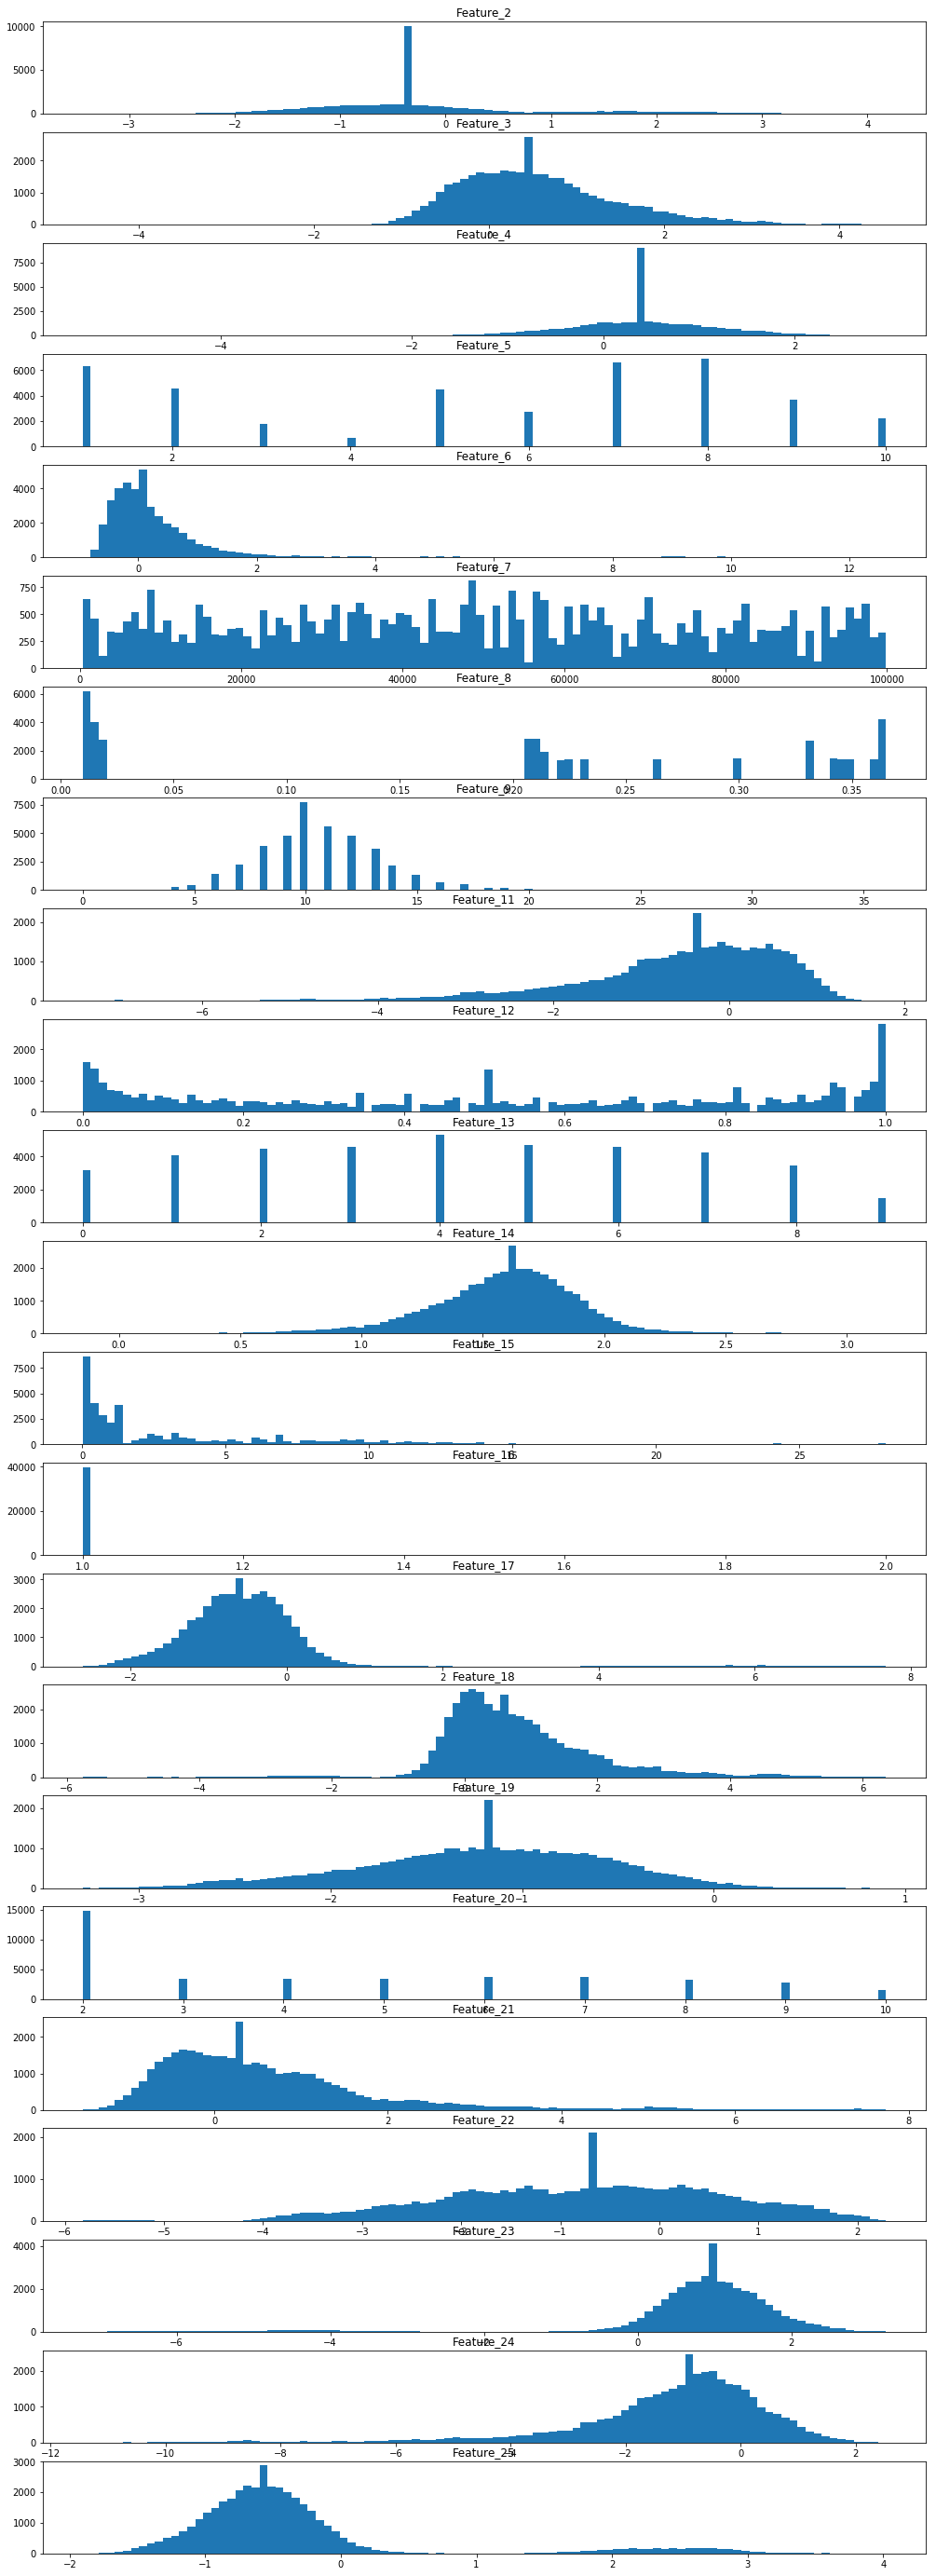

In [10]:
# Feature Histograms
plt.figure(figsize=(17,50))

feat_hist(x2)

Most Features appear fairly normal though a few do have some heavy skew.  They all fall in a fairly narrow range and as such most shouldn't need rescaling.  I'm a little hesitant though without actually knowing what these features are or what transformations they've already been through but Feature 7 almost certainly should be scaled and centered. I suspect at least some of these features are results from a PCA.  

A few features have discrete values over a short range and so are likely categorical. Namely Features 5, 13, and 20.  Feature 16 is a heavily imbalanced binary with only a couple hundred examples of the lesser class.  Feature 9 is a little strange.  It is discrete but still appears to have a normal distribution implying the order means something.  It contains values from 0 to 36 though there are single digit counts of the extreme values; the vast majority of examples are clustered around 10.  Feature 13 also appears to have something of a regular distribution but to a lesser extent.

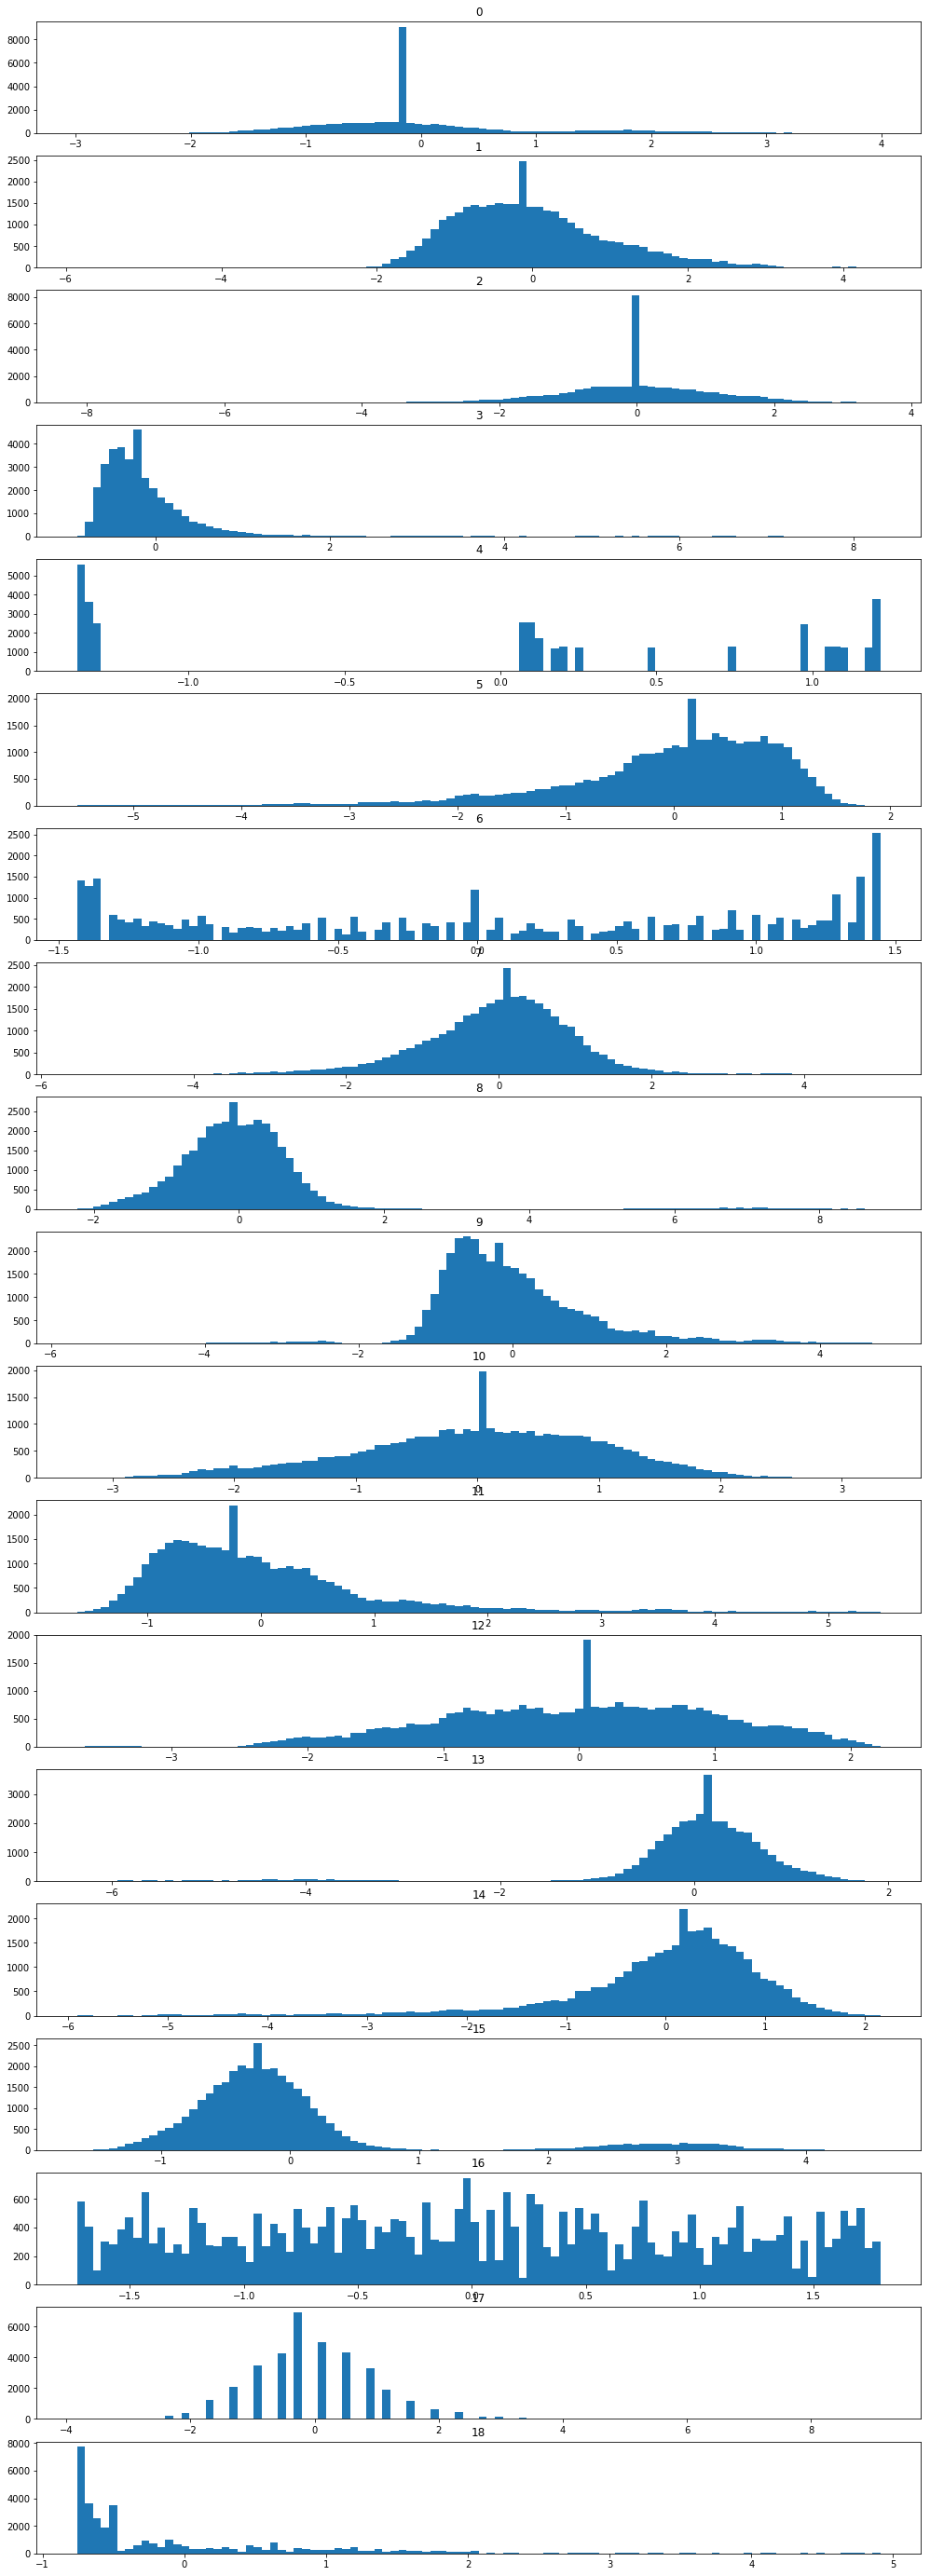

In [11]:
# Check Scaling all compared to only centering above
scale = ['Feature_7', 'Feature_9', 'Feature_15']
cats = ['Feature_5', 'Feature_13', 'Feature_16', 'Feature_20']
center = [i for i in keep if i not in scale and i not in cats]
ascale = center + scale

ctrans =  ColumnTransformer(
    [('scale_all', StandardScaler(), ascale),
     ('cats', OneHotEncoder(categories='auto'), cats)])

# Fit transformers only on train set
X_train_ft_scale = ctrans.fit_transform(X_train_ft.copy())
X_test_ft_scale = ctrans.transform(X_test_ft.copy())

hist_check = pd.DataFrame(X_train_ft_scale[:,:19])
plt.figure(figsize=(17,50))
feat_hist(hist_check)

Scaling and centering only had mild effects as the means and standard deviations of most were already close to 0 and 1 respectively.  Still, I think doing it made the values that much more comperable and a few features clearly needed it (I'm looking at you Feature_7).

In [12]:

tssc = StandardScaler()
X_train_ts_sc = tssc.fit_transform(X_train_ts)
X_test_ts_sc = tssc.transform(X_test_ts)

ytsc = StandardScaler()
y_train_sc = ytsc.fit_transform(y_train)
y_test_sc = ytsc.transform(y_test)

xsc_check = pd.DataFrame(X_train_ts_sc)
xsc_check.columns = X_train_ts.columns
ysc_check = pd.DataFrame(y_train_sc)
ysc_check.columns = y_train.columns

# Stationarity Checks

### Visual

#### Raw

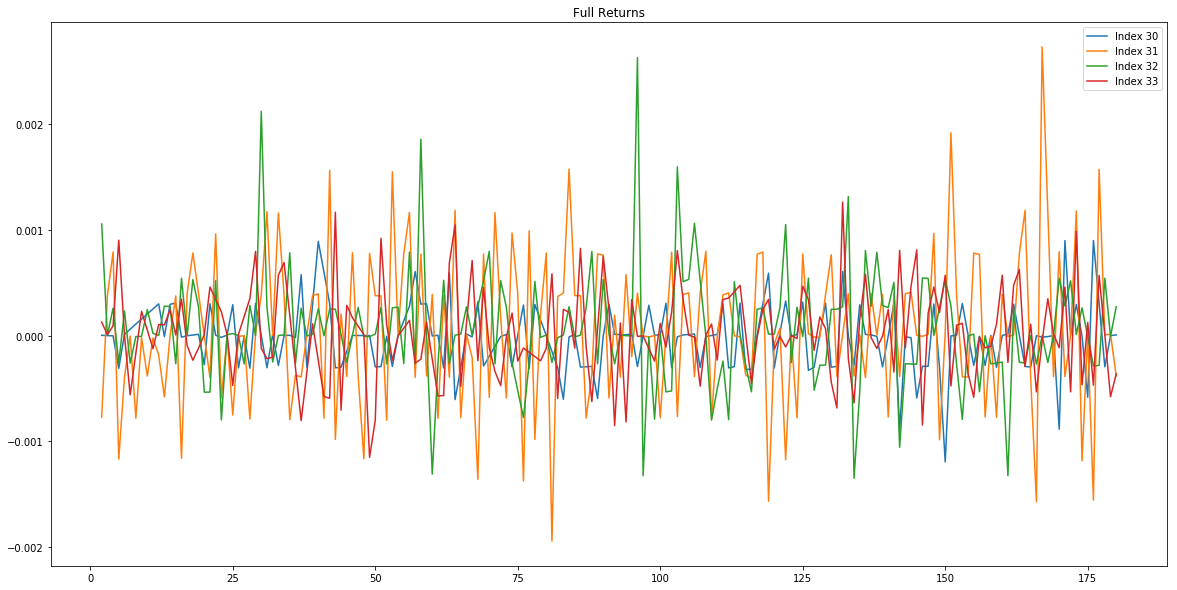

In [9]:
plt.figure(figsize=(20,10))
ynw = y.iloc[:,:-2]
full_ts = pd.concat([x,ynw], axis=1)
full_ts_plt = full_ts.iloc[:,:-2]
ts_line(full_ts_plt, 30, 34, title='Full Returns')

#### Transformed

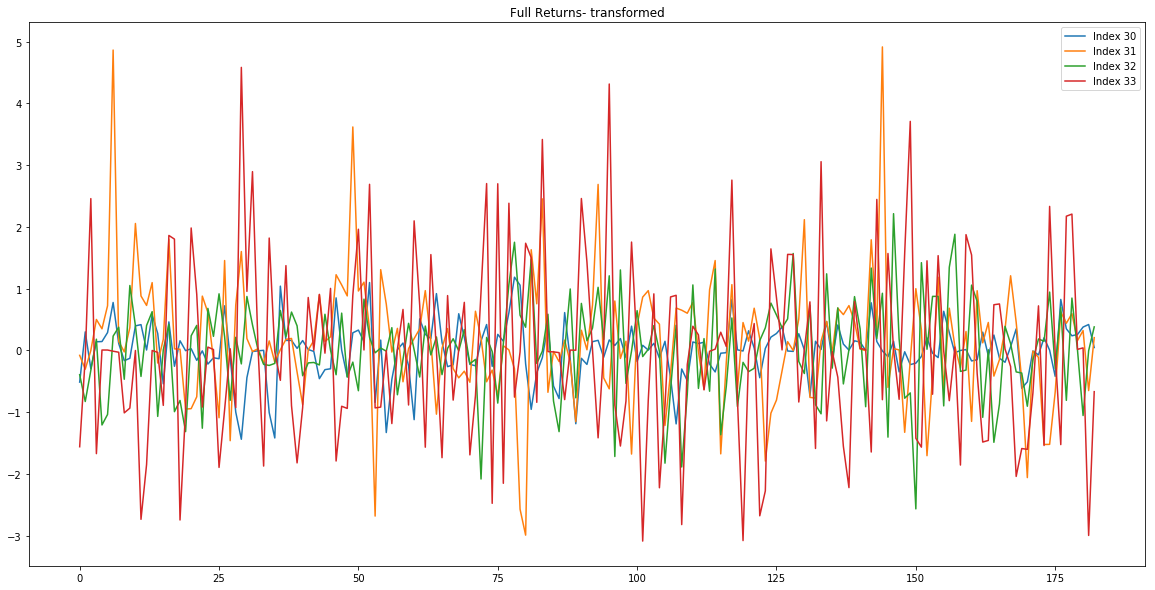

In [102]:
plt.figure(figsize=(20,10))
full_ts_tx = pd.concat([xsc_check,ysc_check], axis=1)
ts_line(full_ts_tx, 30, 34, f2=True, title='Full Returns- transformed')

Visually examining a handful of returns there don't seem to be any aggregious violations of stationarity.  However, the first two time periods (Minus_One and Minus_Two, not pictured) and the extra days of returns (also not pictured). generally have an absolute value far greater than the rest of the intervals.  It's unclear at this time if these.  will cause issues.  The Minus points are displayed in the transformed data and they seem to not have a dramatic effect.  At this point the transformed data may be better to use even if the untransformed doesn't look non-stationary.

In the meantime stationarity will be checked statistically and whichever form (transformed vs. untransformed) looks better will be selected for use in the Model Screening.

### Dickey-Fuller

#### Raw

In [10]:
# Run Augmented Dickey-Fuller on time series Data
y_check = y.iloc[:,:-2]

non_stat_x = adf_rows(x)
non_stat_y = adf_rows(y_check)

xnrows = len(non_stat_x)
xtotal = len(x)
ynrows = len(non_stat_y)
ytotal = len(y)

print('Number Non-Stationary rows in X: {} -- {:.4f}%'.format(xnrows, (100*(xnrows/xtotal))))
print('Number Non-Stationary rows in Y: {} -- {:.4f}%'.format(ynrows, (100*(ynrows/ytotal))))

Number Non-Stationary rows in X: 6 -- 0.0150%
Number Non-Stationary rows in Y: 12076 -- 30.1900%


In [11]:
# ADF on complete TS data
non_stat_all = adf_rows(full_ts)

nrows_all = len(non_stat_all)
total_all = len(full_ts)

print('Number Non-Stationary rows in Full TS: {} -- {:.4f}%'.format(nrows_all, (100*(nrows_all/total_all))))

Number Non-Stationary rows in Full TS: 2336 -- 5.8400%


A very small number of training rows display evidence of non-stationarity throught the Dickey-Fuller test.  It seems unlikely these rows will have an overly dramatic effect on the models performance just by virtue of representing such a small percentage of the total data. However, examples such as these may have practical significance in terms of the future returns so returning to this issue is probably a good idea once the desired architecture has been found. 

The Target values on the other hand have a much larger percentage of non-stationary values which is a little surprising since they don't appear too diffent visually but regardless should be problematic.  The full timeseries has a lower rate of non-stationary examples but still is a little high.

#### Transformed

In [80]:
# Run Augmented Dickey-Fuller on time series Data

non_stat_x = adf_rows(xsc_check)
non_stat_y = adf_rows(ysc_check)

xnrows = len(non_stat_x)
xtotal = len(xsc_check)
ynrows = len(non_stat_y)
ytotal = len(ysc_check)

print('Number Non-Stationary rows in X: {} -- {:.4f}%'.format(xnrows, (100*(xnrows/xtotal))))
print('Number Non-Stationary rows in Y: {} -- {:.4f}%'.format(ynrows, (100*(ynrows/ytotal))))

Number Non-Stationary rows in X: 11 -- 0.0410%
Number Non-Stationary rows in Y: 95 -- 0.3545%


In [83]:
# ADF on complete TS data
non_stat_all = adf_rows(full_ts_tx)

nrows_all = len(non_stat_all)
total_all = len(full_ts_tx)

print('Number Non-Stationary rows in Full TS: {} -- {:.4f}%'.format(nrows_all, (100*(nrows_all/total_all))))

Number Non-Stationary rows in Full TS: 7 -- 0.0261%


The transformation had a profound effect on lowering the rate of non-stationary examples.  It would be expected that using the transformed data would be far more preferable than the untransformed.

#### Raw

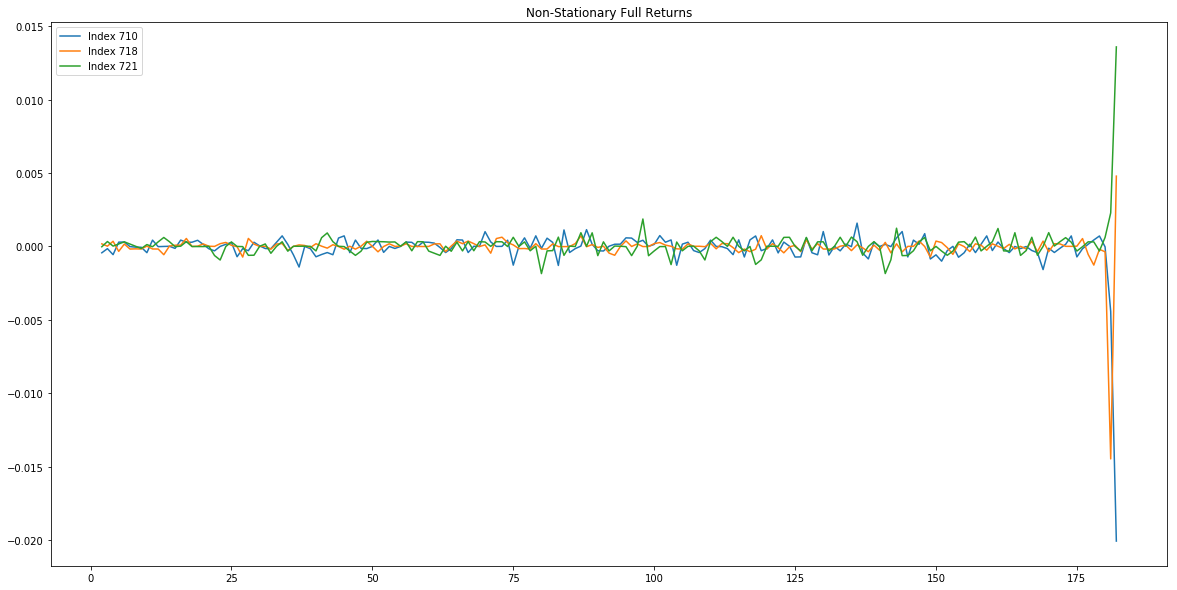

In [12]:
# Plot some p > 0.05 returns
inds = [710,718,721]
inds = [8337,8883,11227]
plt.figure(figsize=(20,10))
ts_line(full_ts, ind_list=inds, title='Non-Stationary Full Returns')

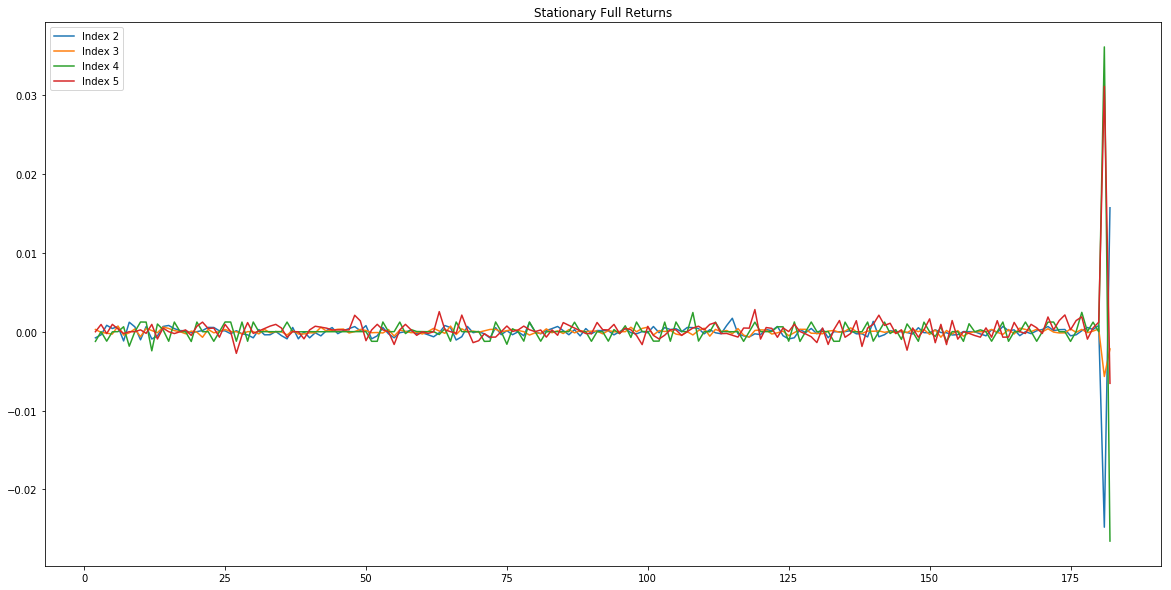

In [13]:
# Plot some p < 0.05 returns
plt.figure(figsize=(20,10))
ts_line(full_ts, 2, 6, title='Stationary Full Returns')

#### Transformed

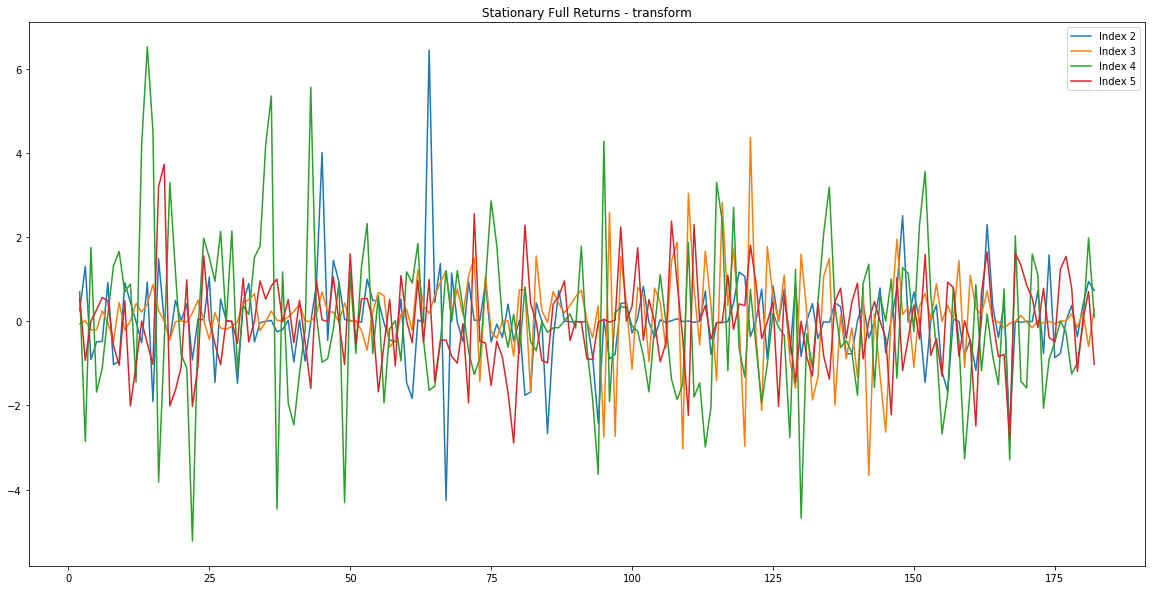

In [72]:
# Plot some p < 0.05 returns
plt.figure(figsize=(20,10))
ts_line(full_ts, 2, 6, title='Stationary Full Returns - transform')

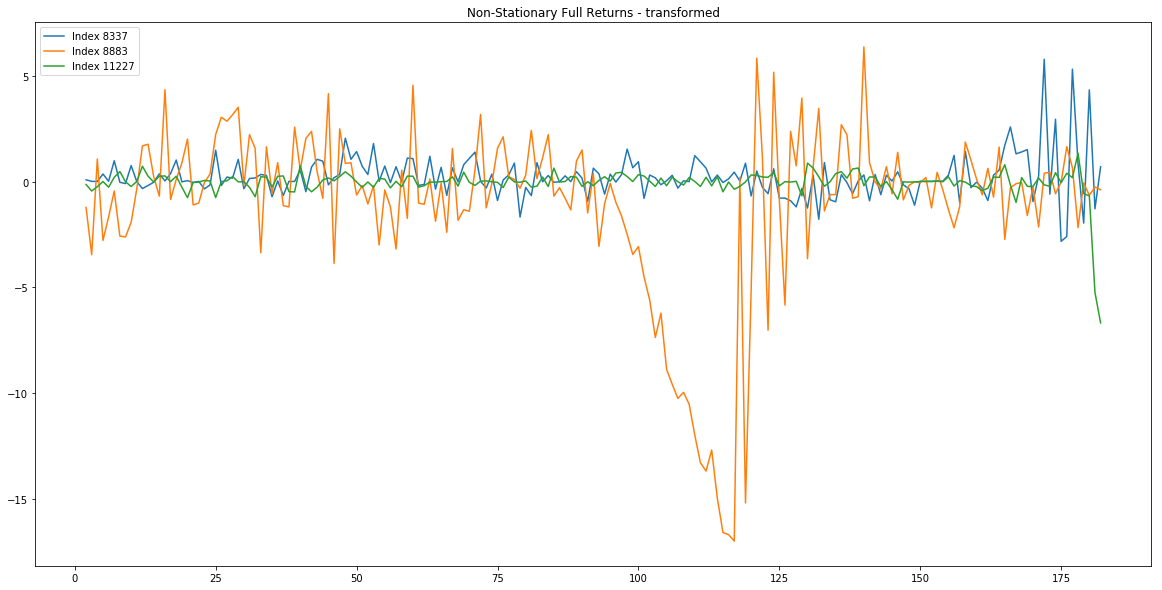

In [85]:
inds = [8337,8883,11227]
plt.figure(figsize=(20,10))
ts_line(full_ts, ind_list=inds, title='Non-Stationary Full Returns - transformed')

Looking at the plots it is difficult to determine what causes the untransformed data to be unstationary.  It could be large, unidirectional returns in the last to points or their size could just be making the violations in the middle of the data more difficult to see.

The non-stationary examples in the transformed data are a little more obvious, especially the one at index 8883.  As they are already differenced and have otherwise been transformed it may be a better option to just exclude the seven rows that were found to be non-stationary. 

Given all the above results the transformed version will be used for building the networks. 

# Model Screen

Below I will quickly run through a few potential architectures that may work well for the data.  At this moment I just want to see if any jump out as looking particularly well suited or are just terrible.  First there is a vanilla MLP as a baseline, then there will be several variations of MLP/CNN hybrid architectues as well as LSTM. I will keep fiddeling to a minimum; at most I will do quick and dirty variations to see if major changes bring about different results.  The other objective is to see the effects of feeding the in the features and timeseries with different methods.

A couple architectures will then be selected to undergo further development and refinement in PyTorch; this is where the systematic fine tuning will happen.

In [13]:
# Reshape data
in_dim = len(xsc_check.columns)
out_dim = len(ysc_check.columns)
in_ft = X_train_ft_scale.shape[1]

X_train_ts = X_train_ts_sc
#X_train_ts = np.asarray(X_train_ts)
base_train = np.concatenate([X_train_ts, X_train_ft], axis=1)
X_train_ts = X_train_ts.reshape((-1,in_dim,1))
X_train_ft = X_train_ft_scale#.reshape((-1,in_ft,1))

X_test_ts = X_test_ts_sc
#X_test_ts = np.asarray(X_test_ts)
base_test = np.concatenate([X_test_ts, X_test_ft], axis=1)
X_test_ts = X_test_ts.reshape((-1,in_dim,1))
X_test_ft = X_test_ft_scale#.reshape((-1,in_ft,1))

y_train = y_train_sc
y_test = y_test_sc

#mods = []

In [14]:
base_train.shape

(36000, 144)

In [ ]:
"""# X/Y split
#exclude = ['Feature_1', 'Feature_10']
#keep = [i for i in ccols if i not in exclude]

x_sub = sub_set.iloc[:,26:147].copy()
x2_sub = sub_set.loc[:,keep].copy()

# Fill in NAs with linear interpolation
x_sub.interpolate(method='linear', axis=1, inplace=True)
# Fill Feature NAs
mode = ['Feature_9', 'Feature_13', 'Feature_16', 'Feature_20']
x2_sub = na_fill(x2_sub, mode)

# Stitch back together
x_fin_sub = pd.concat([x2_sub,x_sub], axis=1)


# Seperate Features and TS
x_fin_sub_ts = x_fin_sub.iloc[:,23:147]

x_fin_sub_ft = x_fin_sub.iloc[:,:23]

x_fin_sub_ts = tssc.transform(x_fin_sub_ts)
x_fin_sub_ft = ctrans.transform(x_fin_sub_ft)

x_fin_all = np.concatenate([x_fin_sub_ts,x_fin_sub_ft], axis=1)"""

In [ ]:
base_train.shape

In [18]:
# RMS Opt
rms = RMSprop(lr=.0001)

### Baseline

In [19]:
set_random_seed(42)
np.random.seed(42)
in_dim_b = base_train.shape[1]



def base():
    model = Sequential()
    model.add(Dense(100, input_dim=in_dim_b))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(out_dim))
    model.add(Activation('linear'))
    
    return model

model = base()
model.compile(optimizer=rms, loss='mean_squared_error', metrics=['mae'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               14500     
_________________________________________________________________
activation_8 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_9 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_10 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)              

In [20]:
test = model.fit(base_train, y_train, validation_data=(base_test, y_test), epochs=10)
#mods.append((test, 'vanilla'))
set_random_seed(42)
np.random.seed(42)

Instructions for updating:
Use tf.cast instead.
Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 3s 74us/step - loss: 2794.8502 - mean_absolute_error: 12.7808 - val_loss: 87.6577 - val_mean_absolute_error: 5.9853
Epoch 2/10
36000/36000 [==============================] - 2s 56us/step - loss: 26.4929 - mean_absolute_error: 3.4022 - val_loss: 25.7088 - val_mean_absolute_error: 3.4761
Epoch 3/10
36000/36000 [==============================] - 2s 55us/step - loss: 12.7342 - mean_absolute_error: 2.3958 - val_loss: 8.5984 - val_mean_absolute_error: 2.0586
Epoch 4/10
36000/36000 [==============================] - 2s 54us/step - loss: 6.5571 - mean_absolute_error: 1.7166 - val_loss: 2.1573 - val_mean_absolute_error: 1.0060
Epoch 5/10
36000/36000 [==============================] - 2s 54us/step - loss: 3.6815 - mean_absolute_error: 1.2833 - val_loss: 1.6209 - val_mean_absolute_error: 0.8665
Epoch 6/10
36000/36000 [==========================

Epoch 1/50
26800/26800 [==============================] - 5s 191us/step - loss: 2290.2126 - mean_absolute_error: 14.6674 - val_loss: 70.0171 - val_mean_absolute_error: 5.8831

Epoch 2/50
26800/26800 [==============================] - 4s 134us/step - loss: 84.9886 - mean_absolute_error: 6.0346 - val_loss: 31.5357 - val_mean_absolute_error: 3.9179

Epoch 50/50
26800/26800 [==============================] - 4s 145us/step - loss: 1.0454 - mean_absolute_error: 0.5701 - val_loss: 1.0737 - val_mean_absolute_error: 0.6126

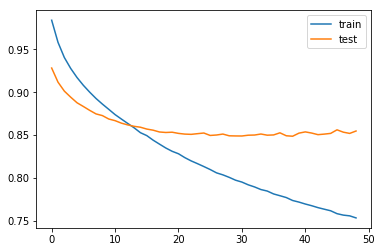

In [65]:
# MAE
plt.plot(test.history['loss'][1:], label='train')
plt.plot(test.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

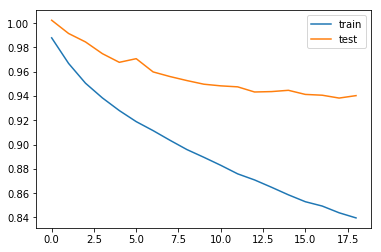

In [18]:
# MSE
plt.plot(test.history['loss'], label='train')
plt.plot(test.history['val_loss'], label='test')
plt.legend()
plt.show()

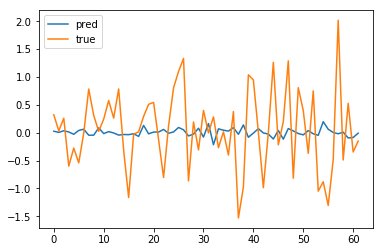

In [25]:
checkvn = model.predict(base_test)
plt.plot(checkvn[45,:], label='pred')
plt.plot(y_test[45,:], label='true')
plt.legend()
plt.show()

In [70]:
base_sub = model.predict(x_fin_all)

make_sub(base_sub, 'vanilla.csv')

**1807 30 epochs**

Initial train loss is very high and there is a jump in validation loss early on but the rest of it looks promising.

In [182]:
del test
del model

### 1d CNN

In [22]:
set_random_seed(42)
np.random.seed(1991)
def cnn_1d():
    cnn = Sequential()

    cnn.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu',input_shape=(in_dim,1)))
    cnn.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
    cnn.add(Conv1D(filters=16, kernel_size=5, padding='same', activation='relu'))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Flatten())
    cnn.add(Dense(300, activation='relu'))
    cnn.add(Dense(300, activation='relu'))
    cnn.add(Dense(300, activation='relu'))
    cnn.add(Dense(300, activation='relu'))
    cnn.add(Dense(300, activation='relu'))
    cnn.add(Dense(300, activation='relu'))
    cnn.add(Dense(out_dim, activation='linear'))

    return cnn

cnn = cnn_1d()
    
cnn.compile(optimizer=rms, loss='mean_absolute_error', metrics=['mse'])
cnn.summary()
    

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 121, 64)           384       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 121, 32)           10272     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 121, 16)           2576      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60, 16)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 300)               288300    
_________________________________________________________________
dense_16 (Dense)             (None, 300)              

In [23]:
set_random_seed(42)
np.random.seed(1991)
cnn_base = cnn.fit(X_train_ts, y_train, epochs=20, validation_data=(X_test_ts, y_test))
#mods.append((cnn_base, '1dCNN'))

Train on 36000 samples, validate on 4000 samples
Epoch 1/20
36000/36000 [==============================] - 33s 906us/step - loss: 0.5469 - mean_squared_error: 1.0001 - val_loss: 0.5434 - val_mean_squared_error: 0.9506
Epoch 2/20
36000/36000 [==============================] - 37s 1ms/step - loss: 0.5450 - mean_squared_error: 0.9795 - val_loss: 0.5398 - val_mean_squared_error: 0.9097
Epoch 3/20
36000/36000 [==============================] - 28s 773us/step - loss: 0.5407 - mean_squared_error: 0.9402 - val_loss: 0.5367 - val_mean_squared_error: 0.8897
Epoch 4/20
36000/36000 [==============================] - 30s 834us/step - loss: 0.5361 - mean_squared_error: 0.9148 - val_loss: 0.5335 - val_mean_squared_error: 0.8733
Epoch 5/20
36000/36000 [==============================] - 28s 773us/step - loss: 0.5318 - mean_squared_error: 0.8955 - val_loss: 0.5305 - val_mean_squared_error: 0.8622
Epoch 6/20
36000/36000 [==============================] - 28s 773us/step - loss: 0.5280 - mean_squared_error

**1796 points submitted**

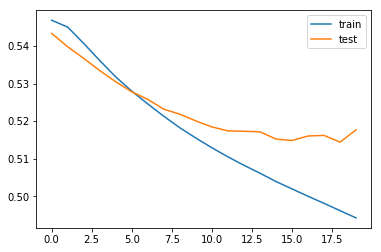

In [24]:
# MAE
plt.plot(cnn_base.history['loss'], label='train')
plt.plot(cnn_base.history['val_loss'], label='test')
plt.legend()
plt.show()

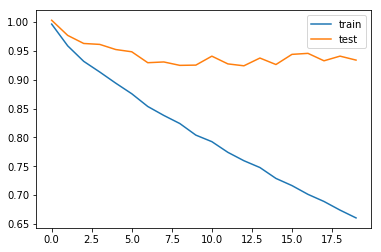

In [25]:
# MSE
plt.plot(cnn_base.history['loss'], label='train')
plt.plot(cnn_base.history['val_loss'], label='test')
plt.legend()
plt.show()

More convolutions and fewer FC layers produce worse results.

In [181]:
del cnn_base
del cnn

### 2d CNN

In [176]:
X_train_ts2d = X_train_ts.reshape(-1,11,11,1)
X_test_ts2d = X_test_ts.reshape(-1,11,11,1)
set_random_seed(42)
np.random.seed(42)

def cnn_2d():
    cnn2d = Sequential()

    cnn2d.add(Conv2D(64, 5, padding='same', activation='relu', input_shape=(11,11,1)))
    cnn2d.add(Conv2D(64, 5, padding='same', activation='relu'))
    cnn2d.add(Conv2D(64, 5, padding='same', activation='relu'))
    cnn2d.add(MaxPooling2D(2))
    cnn2d.add(Flatten())
    cnn2d.add(Dense(500, activation='relu'))
    cnn2d.add(Dense(500, activation='relu'))
    cnn2d.add(Dense(500, activation='relu'))
    cnn2d.add(Dense(500, activation='relu'))
    cnn2d.add(Dense(500, activation='relu'))
    cnn2d.add(Dense(500, activation='relu'))
    cnn2d.add(Dense(out_dim, activation='linear'))
    
    return cnn2d

cnn2d = cnn_2d()

cnn2d.compile(optimizer=rms, loss='mean_squared_error', metrics=['mae'])
cnn2d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 11, 11, 64)        1664      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 64)        102464    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 11, 11, 64)        102464    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_131 (Dense)            (None, 500)               800500    
_________________________________________________________________
dense_132 (Dense)            (None, 500)               250500    
__________

In [177]:
set_random_seed(42)
np.random.seed(42)
cnn2_base = cnn2d.fit(X_train_ts2d, y_train, epochs=9, validation_data=(X_test_ts2d, y_test))
#mods.append((cnn2_base, '2dCNN'))

Train on 36000 samples, validate on 4000 samples
Epoch 1/9
36000/36000 [==============================] - 11s 310us/step - loss: 0.9815 - mean_absolute_error: 0.5482 - val_loss: 0.9156 - val_mean_absolute_error: 0.5432
Epoch 2/9
36000/36000 [==============================] - 10s 267us/step - loss: 0.9493 - mean_absolute_error: 0.5449 - val_loss: 0.8936 - val_mean_absolute_error: 0.5407
Epoch 3/9
36000/36000 [==============================] - 10s 269us/step - loss: 0.9183 - mean_absolute_error: 0.5415 - val_loss: 0.8701 - val_mean_absolute_error: 0.5376
Epoch 4/9
36000/36000 [==============================] - 10s 268us/step - loss: 0.8873 - mean_absolute_error: 0.5367 - val_loss: 0.8563 - val_mean_absolute_error: 0.5342
Epoch 5/9
36000/36000 [==============================] - 10s 269us/step - loss: 0.8659 - mean_absolute_error: 0.5325 - val_loss: 0.8454 - val_mean_absolute_error: 0.5329
Epoch 6/9
36000/36000 [==============================] - 10s 271us/step - loss: 0.8424 - mean_absolut

**1814 sub score**

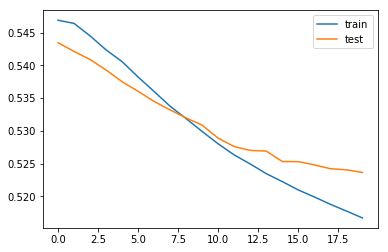

In [68]:
# MAE
plt.plot(cnn2_base.history['loss'], label='train')
plt.plot(cnn2_base.history['val_loss'], label='test')
plt.legend()
plt.show()

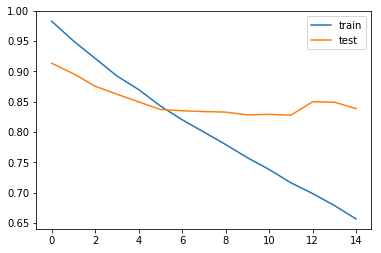

In [175]:
# MSE
plt.plot(cnn2_base.history['loss'], label='train')
plt.plot(cnn2_base.history['val_loss'], label='test')
plt.legend()
plt.show()

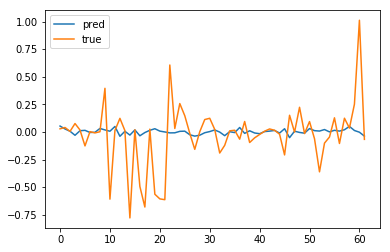

In [174]:
checkvn = cnn2d.predict(X_test_ts2d)
plt.plot(check2d[10,:], label='pred')
plt.plot(y_test[10,:], label='true')
plt.legend()
plt.show()

In [178]:
sub_2d = x_fin_sub_ts.reshape(-1,11,11,1)
subpred = cnn2d.predict(sub_2d)

make_sub(subpred, '2dcnn.csv')

In [180]:
del cnn2_base
del cnn2d

### Dual-In CNN + FT/TS-MLP

In [23]:
in_dim_b = base_train.shape[1]


def dual_cnn_FTTSmlp():
    # CNN Side
    in1 = Input(shape=(in_dim,1))
    cnn1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(in1)
    cnn2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn1)
    cnn3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn2)
    max1 = MaxPooling1D(pool_size=2)(cnn3)
    flat1 = Flatten()(max1)
    # MLP Side
    in2 = Input(shape=(in_dim_b,))
    ft_den1 = Dense(100)(in2)
    lrel1 = LeakyReLU()(ft_den1)
    ft_den2 = Dense(100)(lrel1)
    lrel2 = LeakyReLU()(ft_den2)


    # Bring Togther
    merge = concatenate([flat1,lrel2])
    hid1 = Dense(1500)(merge)
    mrel1 = LeakyReLU()(hid1)
    hid2 = Dense(1500)(mrel1)
    mrel2 = LeakyReLU()(hid2)
    hid3 = Dense(1500)(mrel2)
    mrel3 = LeakyReLU()(hid3)
    hid4 = Dense(1500)(mrel3)
    mrel4 = LeakyReLU()(hid4)
    hid5 = Dense(1500)(mrel4)
    mrel5 = LeakyReLU()(hid5)
    out = Dense(out_dim, activation='linear')(mrel3)

    cnn_mlp = Model(inputs=[in1,in2], outputs=out)
    
    return cnn_mlp

cnn_mlp = dual_cnn_FTTSmlp()

print(cnn_mlp.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 121, 1)       0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 121, 64)      256         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 144)          0                                            
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 121, 64)      12352       conv1d_4[0][0]                   
__________________________________________________________________________________________________
dense_22 (

In [24]:
cnn_mlp.compile(optimizer=rms, loss='mean_absolute_error', metrics=['mse'])
m1 = cnn_mlp.fit([X_train_ts,base_train], y_train, epochs=7, validation_data=([X_test_ts,base_test], y_test))

Train on 26800 samples, validate on 13200 samples
Epoch 1/10
26800/26800 [==============================] - 14s 515us/step - loss: 8.4251 - mean_squared_error: 1200.3598 - val_loss: 0.6821 - val_mean_squared_error: 1.2095
Epoch 2/10
26800/26800 [==============================] - 13s 484us/step - loss: 0.7313 - mean_squared_error: 1.4807 - val_loss: 0.5706 - val_mean_squared_error: 1.0340
Epoch 3/10
26800/26800 [==============================] - 14s 515us/step - loss: 0.6053 - mean_squared_error: 1.0788 - val_loss: 0.5590 - val_mean_squared_error: 0.9947
Epoch 4/10
26800/26800 [==============================] - 13s 477us/step - loss: 0.5766 - mean_squared_error: 0.9964 - val_loss: 0.5516 - val_mean_squared_error: 0.9701
Epoch 5/10
26800/26800 [==============================] - 13s 474us/step - loss: 0.5641 - mean_squared_error: 0.9488 - val_loss: 0.5489 - val_mean_squared_error: 0.9530
Epoch 6/10
26800/26800 [==============================] - 13s 476us/step - loss: 0.5579 - mean_squared

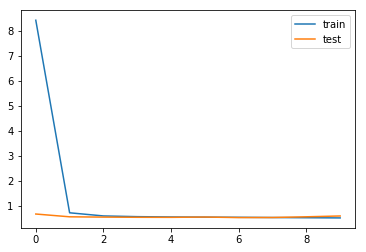

In [25]:
# MAE
plt.plot(m1.history['loss'], label='train')
plt.plot(m1.history['val_loss'], label='test')
plt.legend()
plt.show()

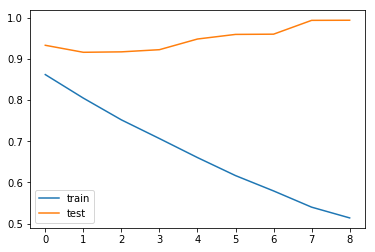

In [33]:
# MSE
plt.plot(m1.history['loss'][1:], label='train')
plt.plot(m1.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

In [ ]:
del m1
del cnn_mlp

### Dual-In CNN + Ft-MLP

In [27]:

def dual_cnn_FTmlp():
    # CNN
    in1 = Input(shape=(in_dim,1))
    cnn1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(in1)
    cnn2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn1)
    cnn3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn2)
    max1 = MaxPooling1D(pool_size=2)(cnn3)
    flat1 = Flatten()(max1)
    # MLP Side
    in2 = Input(shape=(50,))
    ft_den1 = Dense(60)(in2)
    lrel1 = LeakyReLU()(ft_den1)
    ft_den2 = Dense(60)(lrel1)
    lrel2 = LeakyReLU()(ft_den2)


    # Bring Togther
    merge = concatenate([flat1,lrel2])
    hid1 = Dense(1500)(merge)
    mrel1 = LeakyReLU()(hid1)
    hid2 = Dense(1500)(mrel1)
    mrel2 = LeakyReLU()(hid2)
    hid3 = Dense(1500)(mrel2)
    mrel3 = LeakyReLU()(hid3)
    hid4 = Dense(1500)(mrel3)
    mrel4 = LeakyReLU()(hid4)
    hid5 = Dense(1500)(mrel4)
    mrel5 = LeakyReLU()(hid5)
    out = Dense(out_dim, activation='linear')(mrel3)

    cnn_mlp2 = Model(inputs=[in1,in2], outputs=out)

    return cnn_mlp2

cnn_mlp2 = dual_cnn_FTmlp()


print(cnn_mlp2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 121, 1)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 121, 64)      256         input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 121, 64)      12352       conv1d_7[0][0]                   
__________________________________________________________________________________________________
dense_30 (

In [28]:
cnn_mlp2.compile(optimizer=rms, loss='mean_absolute_error', metrics=['mse'])
m12 = cnn_mlp2.fit([X_train_ts,X_train_ft], y_train, epochs=5, validation_data=([X_test_ts,X_test_ft], y_test))
mods.append((m12, 'dual_FTmlp'))

Train on 26800 samples, validate on 13200 samples
Epoch 1/5
26800/26800 [==============================] - 15s 550us/step - loss: 0.5487 - mean_squared_error: 0.9729 - val_loss: 0.5397 - val_mean_squared_error: 0.9535
Epoch 2/5
26800/26800 [==============================] - 13s 471us/step - loss: 0.5349 - mean_squared_error: 0.8913 - val_loss: 0.5319 - val_mean_squared_error: 0.9282
Epoch 3/5
26800/26800 [==============================] - 13s 468us/step - loss: 0.5235 - mean_squared_error: 0.8379 - val_loss: 0.5285 - val_mean_squared_error: 0.9176
Epoch 4/5
26800/26800 [==============================] - 13s 468us/step - loss: 0.5139 - mean_squared_error: 0.8009 - val_loss: 0.5262 - val_mean_squared_error: 0.8994
Epoch 5/5
26800/26800 [==============================] - 13s 470us/step - loss: 0.5048 - mean_squared_error: 0.7635 - val_loss: 0.5249 - val_mean_squared_error: 0.8953


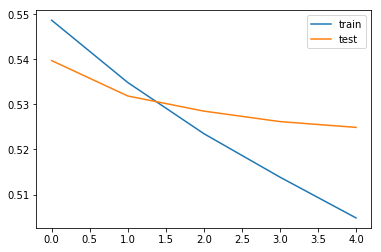

In [29]:
# MAE
plt.plot(m12.history['loss'], label='train')
plt.plot(m12.history['val_loss'], label='test')
plt.legend()
plt.show()

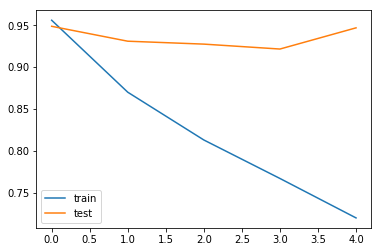

In [37]:
# MSE
plt.plot(m12.history['loss'], label='train')
plt.plot(m12.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
del m12
del cnn_mlp2

### Dual in TS-MLP

In [39]:
set_random_seed(42)
np.random.seed(42)

def dual_cnn_TSmlp():
    # CNN
    in1 = Input(shape=(in_dim,1))
    cnn1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(in1)
    cnn2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn1)
    cnn3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn2)
    max1 = MaxPooling1D(pool_size=2)(cnn3)
    flat1 = Flatten()(max1)
    # MLP Side
    in2 = Input(shape=(in_dim,))
    ft_den1 = Dense(90)(in2)
    lrel1 = LeakyReLU()(ft_den1)
    ft_den2 = Dense(90)(lrel1)
    lrel2 = LeakyReLU()(ft_den2)


    # Bring Togther
    merge = concatenate([flat1,lrel2])
    hid1 = Dense(1500)(merge)
    mrel1 = LeakyReLU()(hid1)
    hid2 = Dense(1500)(mrel1)
    mrel2 = LeakyReLU()(hid2)
    hid3 = Dense(1500)(mrel2)
    mrel3 = LeakyReLU()(hid3)
    hid4 = Dense(1500)(mrel3)
    mrel4 = LeakyReLU()(hid4)
    hid5 = Dense(1500)(mrel4)
    mrel5 = LeakyReLU()(hid5)
    out = Dense(out_dim, activation='linear')(mrel3)

    cnn_mlp2 = Model(inputs=[in1,in2], outputs=out)

    return cnn_mlp2

cnn_mlp2ts = dual_cnn_TSmlp()


print(cnn_mlp2ts.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 121, 1)       0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 121, 64)      256         input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 121)          0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 121, 64)      12352       conv1d_13[0][0]                  
__________________________________________________________________________________________________
dense_33 (

In [40]:
set_random_seed(42)
np.random.seed(42)
X_tr_ts_2 = X_train_ts.reshape((-1,121))
X_ts_ts_2 = X_test_ts.reshape((-1,121))
cnn_mlp2ts.compile(optimizer=rms, loss='mean_absolute_error', metrics=['mse'])
m12ts = cnn_mlp2ts.fit([X_train_ts,X_tr_ts_2], y_train, epochs=10, validation_data=([X_test_ts,X_ts_ts_2], y_test))
#mods.append((m12, 'dual_FTmlp'))

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 18s 512us/step - loss: 0.5424 - mean_squared_error: 0.9492 - val_loss: 0.5317 - val_mean_squared_error: 0.8601
Epoch 2/10
36000/36000 [==============================] - 16s 450us/step - loss: 0.5257 - mean_squared_error: 0.8680 - val_loss: 0.5235 - val_mean_squared_error: 0.8302
Epoch 3/10
36000/36000 [==============================] - 16s 451us/step - loss: 0.5145 - mean_squared_error: 0.8223 - val_loss: 0.5181 - val_mean_squared_error: 0.8092
Epoch 4/10
36000/36000 [==============================] - 17s 470us/step - loss: 0.5054 - mean_squared_error: 0.7859 - val_loss: 0.5165 - val_mean_squared_error: 0.8043
Epoch 5/10
36000/36000 [==============================] - 16s 449us/step - loss: 0.4968 - mean_squared_error: 0.7549 - val_loss: 0.5151 - val_mean_squared_error: 0.7957
Epoch 6/10
36000/36000 [==============================] - 16s 450us/step - loss: 0.4879 - mean_squared_err

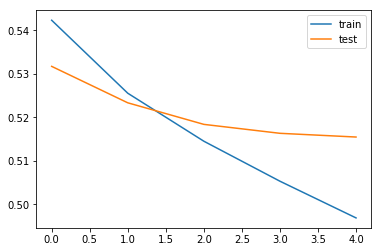

In [25]:
# MAE
plt.plot(m12ts.history['loss'], label='train')
plt.plot(m12ts.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# MSE
plt.plot(m12ts.history['loss'], label='train')
plt.plot(m12ts.history['val_loss'], label='test')
plt.legend()
plt.show()

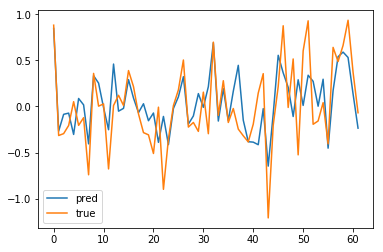

In [38]:
dts = cnn_mlp2ts.predict([X_test_ts,X_ts_ts_2])
plt.plot(dts[20,:], label='pred')
plt.plot(y_test[20,:], label='true')
plt.legend()
plt.show()

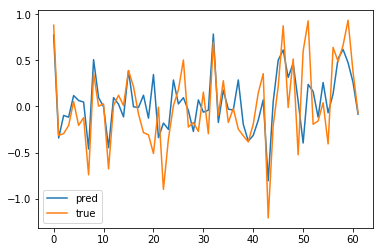

In [220]:
dts = cnn_mlp2ts.predict([X_test_ts,X_ts_ts_2])
plt.plot(dts[20,:], label='pred')
plt.plot(y_test[20,:], label='true')
plt.legend()
plt.show()

In [41]:
x_fin2d = x_fin_sub_ts.reshape((-1,121))
x_fin_sub_ts = x_fin_sub_ts.reshape((-1,121,1))
dts_sub = cnn_mlp2ts.predict([x_fin_sub_ts,x_fin2d])

make_sub(dts_sub,'cnn+TSmlp10.csv')

**1814, 5 epochs**

### Tri-In CNN + TS/Ft-MLP

In [197]:

def triple_in():
    # CNN Side
    in1 = Input(shape=(in_dim,1))
    cnn1 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(in1)
    cnn2 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(cnn1)
    cn_bn = BatchNormalization()(cnn2)
    cnn3 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(cn_bn)
    cnn4 = Conv1D(filters=64, kernel_size=5, padding='same', activation='relu')(cnn3)
    cn_bn2 = BatchNormalization()(cnn4)
    max1 = MaxPooling1D(pool_size=2)(cn_bn2)
    flat1 = Flatten()(max1)

    # MLP for TS
    in3 = Input(shape=(in_dim,1))
    flat2 = Flatten()(in3)
    ts_den1 = Dense(90)(flat2)
    tsrel1 = LeakyReLU()(ts_den1)
    ts_den2 = Dense(90)(tsrel1)
    tsrel2 = LeakyReLU()(ts_den2)
    ts_bn = BatchNormalization()(tsrel2)
    ts_den3 = Dense(90)(ts_bn)
    tsrel3 = LeakyReLU()(ts_den3)
    ts_bn2 = BatchNormalization()(tsrel3)


    # MLP Side Features
    in2 = Input(shape=(50,))
    ft_den1 = Dense(60)(in2)
    lrel1 = LeakyReLU()(ft_den1)
    ft_den2 = Dense(60)(lrel1)
    lrel2 = LeakyReLU()(ft_den2)
    ft_bn = BatchNormalization()(lrel2)
    ft_den3 = Dense(60)(ft_bn)
    lrel3 = LeakyReLU()(ft_den3)
    ft_bn2 = BatchNormalization()(lrel3)

    # Bring Togther
    merge = concatenate([flat1,ts_bn2,ft_bn2])
    hid1 = Dense(2000)(merge)
    mrel1 = LeakyReLU()(hid1)
    dr1 = Dropout(0.5)(mrel1)
    hid2 = Dense(2000)(dr1)
    mrel2 = LeakyReLU()(hid2)
    hid3 = Dense(2000)(mrel2)
    dr2 = Dropout(0.5)(hid3)
    mrel3 = LeakyReLU()(dr2)
    hid4 = Dense(2000)(mrel3)
    mrel4 = LeakyReLU()(hid4)
    dr3 = Dropout(0.5)(mrel4)
    hid5 = Dense(2000)(dr3)
    mrel5 = LeakyReLU()(hid5)
    dr4 = Dropout(0.5)(mrel5)
    hid6 = Dense(2000)(dr4)
    mrel6 = LeakyReLU()(hid6)
    out = Dense(out_dim, activation='linear')(mrel6)

    cnn_2x_mlp = Model(inputs=[in1,in3,in2], outputs=out)

    return cnn_2x_mlp

cnn_2x_mlp = triple_in()

print(cnn_2x_mlp.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 121, 1)       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 121, 1)       0                                            
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 121)          0           input_11[0][0]                   
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 50)           0                                            
__________________________________________________________________________________________________
conv1d_28 

In [198]:
cnn_2x_mlp.compile(optimizer=rms, loss='mean_absolute_error', metrics=['mse'])

In [199]:
m2 = cnn_2x_mlp.fit([X_train_ts,X_train_ts,X_train_ft], y_train, epochs=30, validation_data=([X_test_ts,X_test_ts,X_test_ft], y_test))


Train on 36000 samples, validate on 4000 samples
Epoch 1/30
36000/36000 [==============================] - 66s 2ms/step - loss: 0.5819 - mean_squared_error: 1.0712 - val_loss: 0.5467 - val_mean_squared_error: 0.9527
Epoch 2/30
36000/36000 [==============================] - 41s 1ms/step - loss: 0.5557 - mean_squared_error: 1.0091 - val_loss: 0.5437 - val_mean_squared_error: 0.9423
Epoch 3/30
36000/36000 [==============================] - 42s 1ms/step - loss: 0.5507 - mean_squared_error: 0.9829 - val_loss: 0.5406 - val_mean_squared_error: 0.9157
Epoch 4/30
36000/36000 [==============================] - 42s 1ms/step - loss: 0.5471 - mean_squared_error: 0.9650 - val_loss: 0.5394 - val_mean_squared_error: 0.9122
Epoch 5/30
36000/36000 [==============================] - 42s 1ms/step - loss: 0.5447 - mean_squared_error: 0.9563 - val_loss: 0.5376 - val_mean_squared_error: 0.9063
Epoch 6/30
36000/36000 [==============================] - 42s 1ms/step - loss: 0.5428 - mean_squared_error: 0.9465 -

**1775.50592 score submitted 10 epochs, 1779 30**

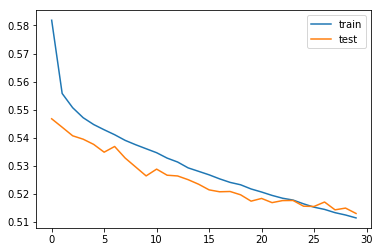

In [201]:
# MAE
plt.plot(m2.history['loss'], label='train')
plt.plot(m2.history['val_loss'], label='test')
plt.legend()
plt.show()

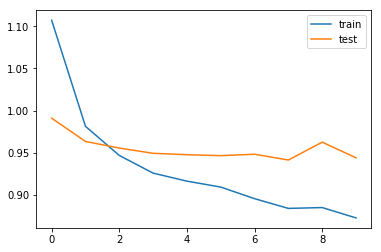

In [ ]:
# MSE
plt.plot(m2.history['loss'], label='train')
plt.plot(m2.history['val_loss'], label='test')
plt.legend()
plt.show()

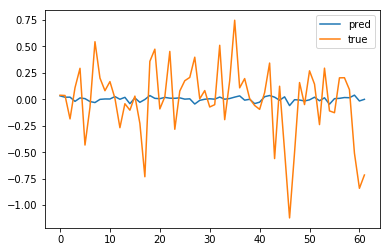

In [204]:
checktri1 = cnn_2x_mlp.predict([X_test_ts,X_test_ts,X_test_ft])
plt.plot(checktri1[32,:], label='pred')
plt.plot(y_test[32,:], label='true')
plt.legend()
plt.show()

In [205]:
#x_fin_sub_ts = np.asarray(x_fin_sub_ts)
x_fin_sub_ts = x_fin_sub_ts.reshape((-1,in_dim,1))
sub_tri = cnn_2x_mlp.predict([x_fin_sub_ts, x_fin_sub_ts, x_fin_sub_ft])

make_sub(sub_tri, 'tri_no_scale30.csv')

In [206]:
del m2
del cnn_2x_mlp

### Dual CNN + Ft-MLP Hybrid

In [37]:


def tri_2xCNN():
    # CNN Side
    in1 = Input(shape=(in_dim,1))
    cnn1 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(in1)
    cnn2 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn1)
    cnn3 = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(cnn2)
    max1 = MaxPooling1D(pool_size=2)(cnn3)
    flat1 = Flatten()(max1)

    # MLP Side
    in2 = Input(shape=(50,))
    ft_den1 = Dense(60)(in2)
    lrel1 = LeakyReLU()(ft_den1)
    ft_den2 = Dense(60)(lrel1)
    lrel2 = LeakyReLU()(ft_den2)
    ft_den3 = Dense(60)(lrel2)
    lrel3 = LeakyReLU()(ft_den3)

    # CNN 2 Side
    in3 = Input(shape=(in_dim,1))
    cnn21 = Conv1D(filters=64, kernel_size=7, padding='same', activation='relu')(in3)
    cnn22 = Conv1D(filters=64, kernel_size=7, padding='same', activation='relu')(cnn21)
    cnn23 = Conv1D(filters=64, kernel_size=7, padding='same', activation='relu')(cnn22)
    max21 = MaxPooling1D(pool_size=2)(cnn23)
    flat21 = Flatten()(max21)


    # Bring Togther
    merge = concatenate([flat1,flat21,lrel3])
    hid1 = Dense(3000)(merge)
    mrel1 = LeakyReLU()(hid1)
    hid2 = Dense(3000)(mrel1)
    mrel2 = LeakyReLU()(hid2)
    hid3 = Dense(3000)(mrel2)
    mrel3 = LeakyReLU()(hid3)
    hid4 = Dense(3000)(mrel3)
    mrel4 = LeakyReLU()(hid4)
    hid5 = Dense(3000)(mrel4)
    mrel5 = LeakyReLU()(hid5)
    out = Dense(out_dim, activation='linear')(mrel3)

    cnn_cnn_mlp = Model(inputs=[in1,in3,in2], outputs=out)

    return cnn_cnn_mlp

cnn_cnn_mlp = tri_2xCNN()
    
print(cnn_cnn_mlp.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 121, 1)       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 121, 1)       0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 60)           3060        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_14 

In [38]:
cnn_cnn_mlp.compile(optimizer=rms, loss='mean_absolute_error', metrics=['mse'])

In [39]:
m3 = cnn_cnn_mlp.fit([X_train_ts,X_train_ts,X_train_ft], y_train, epochs=10, validation_data=([X_test_ts,X_test_ts,X_test_ft], y_test))

Train on 26800 samples, validate on 13200 samples
Epoch 1/10
26800/26800 [==============================] - 40s 1ms/step - loss: 0.5447 - mean_squared_error: 0.9442 - val_loss: 0.5331 - val_mean_squared_error: 0.9242
Epoch 2/10
26800/26800 [==============================] - 38s 1ms/step - loss: 0.5248 - mean_squared_error: 0.8525 - val_loss: 0.5248 - val_mean_squared_error: 0.8926
Epoch 3/10
26800/26800 [==============================] - 37s 1ms/step - loss: 0.5093 - mean_squared_error: 0.7883 - val_loss: 0.5226 - val_mean_squared_error: 0.8845
Epoch 4/10
26800/26800 [==============================] - 38s 1ms/step - loss: 0.4935 - mean_squared_error: 0.7305 - val_loss: 0.5236 - val_mean_squared_error: 0.8832
Epoch 5/10
26800/26800 [==============================] - 38s 1ms/step - loss: 0.4772 - mean_squared_error: 0.6734 - val_loss: 0.5289 - val_mean_squared_error: 0.8970
Epoch 6/10
26800/26800 [==============================] - 37s 1ms/step - loss: 0.4614 - mean_squared_error: 0.6223 

In [ ]:
# MAE
plt.plot(m3.history['loss'], label='train')
plt.plot(m3.history['val_loss'], label='test')
plt.legend()
plt.show()

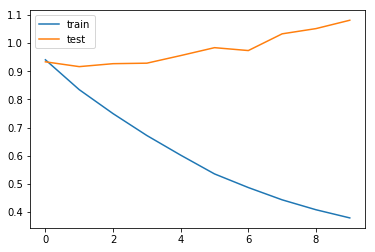

In [ ]:
# MSE
plt.plot(m3.history['loss'], label='train')
plt.plot(m3.history['val_loss'], label='test')
plt.legend()
plt.show()

In [41]:
del m3
del cnn_cnn_mlp

### LSTM

In [74]:
ls1 = Sequential()

ls1.add(LSTM(25, return_sequences=True, input_shape=(121,1)))
ls1.add(LSTM(25, return_sequences=True))
ls1.add(LSTM(25, return_sequences=True))
ls1.add(LSTM(25, return_sequences=True))
ls1.add(LSTM(25, return_sequences=True))
ls1.add(LSTM(25, return_sequences=True))
ls1.add(Flatten())
ls1.add(Dense(out_dim, activation='linear'))

rms2 = RMSprop(lr=.001)
ls1.compile(optimizer=rms2, loss='mean_absolute_error', metrics=['mse'])
ls1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 121, 25)           2700      
_________________________________________________________________
lstm_14 (LSTM)               (None, 121, 25)           5100      
_________________________________________________________________
lstm_15 (LSTM)               (None, 121, 25)           5100      
_________________________________________________________________
lstm_16 (LSTM)               (None, 121, 25)           5100      
_________________________________________________________________
lstm_17 (LSTM)               (None, 121, 25)           5100      
_________________________________________________________________
lstm_18 (LSTM)               (None, 121, 25)           5100      
_________________________________________________________________
flatten_8 (Flatten)          (None, 3025)              0         
__________

In [75]:
ls1t = ls1.fit(X_train_ts, y_train, epochs=10, validation_data=(X_test_ts, y_test))

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 1073s 30ms/step - loss: 0.5468 - mean_squared_error: 0.9975 - val_loss: 0.5430 - val_mean_squared_error: 0.9435
Epoch 2/10
36000/36000 [==============================] - 1062s 29ms/step - loss: 0.5458 - mean_squared_error: 0.9805 - val_loss: 0.5426 - val_mean_squared_error: 0.9404
Epoch 3/10
36000/36000 [==============================] - 1065s 30ms/step - loss: 0.5446 - mean_squared_error: 0.9700 - val_loss: 0.5416 - val_mean_squared_error: 0.9267
Epoch 4/10
36000/36000 [==============================] - 1071s 30ms/step - loss: 0.5437 - mean_squared_error: 0.9629 - val_loss: 0.5410 - val_mean_squared_error: 0.9211
Epoch 5/10
36000/36000 [==============================] - 1050s 29ms/step - loss: 0.5427 - mean_squared_error: 0.9542 - val_loss: 0.5408 - val_mean_squared_error: 0.9184
Epoch 6/10
36000/36000 [==============================] - 1073s 30ms/step - loss: 0.5420 - mean_squar

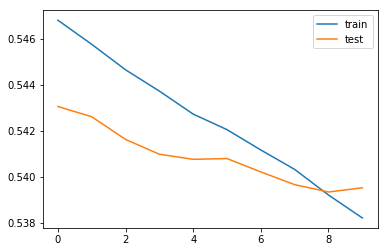

In [76]:
# MAE
plt.plot(ls1t.history['loss'], label='train')
plt.plot(ls1t.history['val_loss'], label='test')
plt.legend()
plt.show()

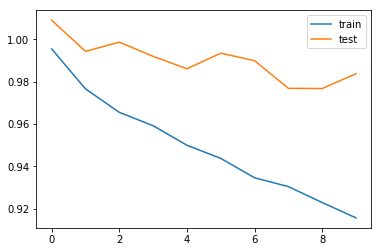

In [ ]:
# MSE
plt.plot(ls1t.history['loss'], label='train')
plt.plot(ls1t.history['val_loss'], label='test')
plt.legend()
plt.show()

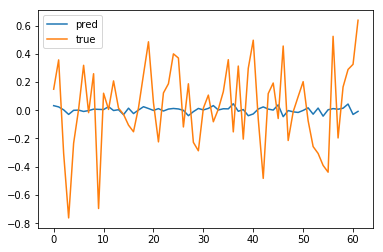

In [78]:
checkls = ls1.predict(X_test_ts)
plt.plot(checkls[85,:], label='pred')
plt.plot(y_test[85,:], label='true')
plt.legend()
plt.show()

In [83]:

x_fin_sub_ts = x_fin_sub_ts.reshape((-1,121,1))
ls_sub = ls1.predict(x_fin_sub_ts)

make_sub(ls_sub, 'lsmt1.csv')

### CNN + LMST Hybrid

In [187]:
cnls1 = Sequential()

cnls1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',input_shape=(in_dim,1)))
cnls1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnls1.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
cnls1.add(MaxPooling1D(pool_size=2))
cnls1.add(LSTM(25, return_sequences=True, input_shape=(60, 64)))
cnls1.add(LSTM(25, return_sequences=True))
cnls1.add(LSTM(25, return_sequences=True))
cnls1.add(LSTM(25, return_sequences=True))
cnls1.add(LSTM(25, return_sequences=True))
cnls1.add(Flatten())
cnls1.add(Dense(out_dim, activation='linear'))

rms2 = RMSprop(lr=.001)
cnls1.compile(optimizer=rms2, loss='mean_absolute_error', metrics=['mse'])
cnls1.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 121, 64)           256       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 121, 64)           12352     
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 121, 64)           12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 60, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 25)            9000      
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 25)            5100      
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 25)            5100      
__________

In [188]:
cnnls = cnls1.fit(X_train_ts, y_train, epochs=13, validation_data=(X_test_ts, y_test))

Train on 36000 samples, validate on 4000 samples
Epoch 1/13
36000/36000 [==============================] - 461s 13ms/step - loss: 0.5469 - mean_squared_error: 1.0000 - val_loss: 0.5434 - val_mean_squared_error: 0.9500
Epoch 2/13
36000/36000 [==============================] - 458s 13ms/step - loss: 0.5463 - mean_squared_error: 0.9906 - val_loss: 0.5426 - val_mean_squared_error: 0.9386
Epoch 3/13
36000/36000 [==============================] - 458s 13ms/step - loss: 0.5452 - mean_squared_error: 0.9762 - val_loss: 0.5421 - val_mean_squared_error: 0.9323
Epoch 4/13
36000/36000 [==============================] - 457s 13ms/step - loss: 0.5444 - mean_squared_error: 0.9688 - val_loss: 0.5411 - val_mean_squared_error: 0.9177
Epoch 5/13
36000/36000 [==============================] - 454s 13ms/step - loss: 0.5437 - mean_squared_error: 0.9649 - val_loss: 0.5416 - val_mean_squared_error: 0.9299
Epoch 6/13
36000/36000 [==============================] - 462s 13ms/step - loss: 0.5430 - mean_squared_err

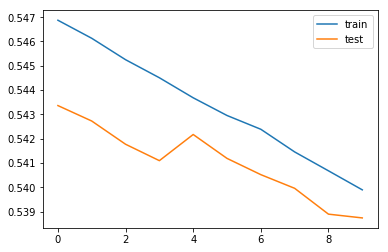

In [186]:
plt.plot(cnls1.history['loss'], label='train')
plt.plot(cnls1.history['val_loss'], label='test')
plt.legend()
plt.show()

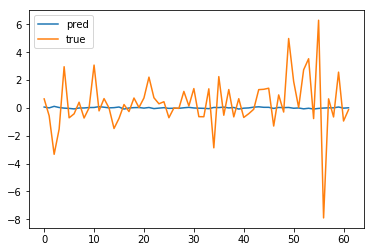

In [190]:
cnls_p = cnls1.predict(X_test_ts)
plt.plot(cnls_p[15,:], label='pred')
plt.plot(y_test[15,:], label='true')
plt.legend()
plt.show()

In [ ]:
x_fin3d = x_fin_sub_ts.reshape((-1,121,1))
#lms_sub = cnls1.predict(x_fin3d)


make_sub(lms_sub, 'CNN_lsmt1.csv')

In [207]:
del cnnls
del cnls1

**1781.80261**

Clearly overfitting is going to be an obstacle no matter the architecture.  The Vanilla MLP and two single input CNNs look promising, with work and overfitting controls either of them could probably do well.  The Triple Input (1x CNN 2x Vanilla) already has dropout and batch normalization which seems to have helped so that could be a good choice for refinement as well.  The Triple Input with 2x CNN overfit very quickly; it may not be worth pursuing immediatley.  The same is true of the Double Input where the time series+features were given to the MLP side.  The other Double input where just the features were given to the MLP side had jump in validation loss in the last epochs but I hesitate to throw it out as it appeared to be doing well up until that point.  These overall patterns are generally true between using MAE and MSE though with MAE the loss tends to be closer. 

The LSTMs learn slowly and take a long time to train.  The CNN hybrid did somehow keep validation loss lower than training and looks like it still has room to improve with more epochs.

Overall none of them really jumped out as working extremely well out of the box.  For the most part they had similar performance so it's difficult to select just one but we can at least eliminate a couple.

On the upside using the scaled timeseries values has produced more stable loss results (others not shown).  Another aspect to take into account is that the competition used a WMAE for evaluation so it'd make sense to use this as our loss function.  I'm not certain though that implementing it at this point would have a dramatic effect on the results but in the next steps it would be a good idea to use. 

#### TEMP

In [142]:
# X/Y split
#exclude = ['Feature_1', 'Feature_10']
#keep = [i for i in ccols if i not in exclude]

x_sub = sub_set.iloc[:,26:147].copy()
x2_sub = sub_set.loc[:,keep].copy()

# Fill in NAs with linear interpolation
x_sub.interpolate(method='linear', axis=1, inplace=True)
# Fill Feature NAs
mode = ['Feature_9', 'Feature_13', 'Feature_16', 'Feature_20']
x2_sub = na_fill(x2_sub, mode)

# Stitch back together
x_fin_sub = pd.concat([x2_sub,x_sub], axis=1)


# Seperate Features and TS
x_fin_sub_ts = x_fin_sub.iloc[:,23:147]

x_fin_sub_ft = x_fin_sub.iloc[:,:23]

x_fin_sub_ts = tssc.transform(x_fin_sub_ts)
x_fin_sub_ft = ctrans.transform(x_fin_sub_ft)

In [29]:
# X/Y split
#exclude = ['Feature_1', 'Feature_10']
#keep = [i for i in ccols if i not in exclude]

x_sub = sub_set.iloc[:,26:147].copy()
x2_sub = sub_set.loc[:,keep].copy()

# Fill in NAs with linear interpolation
x_sub.interpolate(method='linear', axis=1, inplace=True)
# Fill Feature NAs
mode = ['Feature_9', 'Feature_13', 'Feature_16', 'Feature_20']
x2_sub = na_fill(x2_sub, mode)

# Stitch back together
x_fin_sub = pd.concat([x2_sub,x_sub], axis=1)


# Seperate Features and TS
x_fin_sub_ts = x_fin_sub.iloc[:,23:147]

x_fin_sub_ft = x_fin_sub.iloc[:,:23]

x_fin_sub_ts = tssc.transform(x_fin_sub_ts)
x_fin_sub_ft = ctrans.transform(x_fin_sub_ft)

In [ ]:
class build_data(BaseEstimator, TransformerMixin):
    """ Loads and Prepares dataset for pytorch"""
    
    def __init__(self, df, drop, split_size=0.33, rand=22391, batch=1, shuffle=True, pin=True):
        self.rand = rand
        self.split_size = split_size
        self.batch = batch
        self.shuffle = shuffle
        self.pin = pin
        
        df = df.astype('float')
        
        ccols = [i for i in df.columns if 'Feature' in i]
        keep = [i for i in ccols if i not in drop]

        self.x = df.iloc[:,26:147]
        self.x2 = df.loc[:,keep]
        self.y = df.iloc[:,147:]
               
    def _na_fill(self,mode):
        for i in self.x2.columns:
            if i in mode:
                self.x2[i] = self.x2[i].fillna(value=self.x2[i].mode()[0])
            else:
                self.x2[i] = self.x2[i].fillna(value=self.x2[i].median())
                
        self.x = self.x.interpolate(method='linear', axis=1)
        self.x_fin = pd.concat([self.x2,self.x], axis=1)
        
    def _split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.x_fin, self.y, test_size=self.split_size, random_state=self.rand)

        # Seperate Features and TS
        self.X_train_ts = X_train.iloc[:,23:147]
        self.X_test_ts = X_test.iloc[:,23:147]

        self.X_train_ft = X_train.iloc[:,:23]
        self.X_test_ft = X_test.iloc[:,:23]

        # Get Weights for MAE
        self.test_wt, self.train_wt = np.asarray(y_test.iloc[:,-2:]), np.asarray(y_train.iloc[:,-2:])
        self.y_test, self.y_train = np.asarray(y_test.iloc[:,:-2]), np.asarray(y_train.iloc[:,:-2])
        
    def _scale(self,stsc,lab):
        ctrans =  ColumnTransformer(
                    [('scale_all', StandardScaler(), stsc),
                     ('cats', OneHotEncoder(categories='auto'), lab)])
        
        xtsc = StandardScaler()
        ytsc = StandardScaler()
        
        self.X_train_ft = ctrans.fit_transform(self.X_train_ft)
        self.X_test_ft = ctrans.transform(self.X_test_ft)
        self.X_train_ts = xtsc.fit_transform(self.X_train_ts)
        self.X_test_ts = xtsc.transform(self.X_test_ts)
        
        self.x_train = np.concatenate([self.X_train_ft, self.X_train_ts], axis=1)
        self.x_test = np.concatenate([self.X_test_ft, self.X_test_ts], axis=1)
        
        self.y_train = ytsc.fit_transform(self.y_train)
        self.y_test = ytsc.transform(self.y_test)
        
        self.xtrans = xtsc
        self.ytrans = ytsc
        
    def fit(self, mode, stsc, lab):
        self._na_fill(mode)
        self._split()
        self._scale(stsc,lab)
        
        torch_x_train, torch_y_train = torch.from_numpy(self.x_train).float(), torch.from_numpy(self.y_train).float()
        torch_x_test, torch_y_test = torch.from_numpy(self.x_test).float(), torch.from_numpy(self.y_test).float()
        
        train = data_utils.TensorDataset(torch_x_train, torch_y_train)
        test = data_utils.TensorDataset(torch_x_test, torch_y_test)
        
        train_loader = data_utils.DataLoader(train, batch_size=self.batch, shuffle=self.shuffle, pin_memory=self.pin)
        test_loader = data_utils.DataLoader(test, batch_size=self.batch, shuffle=self.shuffle, pin_memory=self.pin)
        
        return train_loader, test_loader
    
    def get_weights(self):
        return self.train_wt, self.test_wt
    
    def reverse_trans(self, x=False, y=False):
        if x is not False:
            return self.xtrans.inverse_transform(x)
        if y is not False:
            return self.ytrans.inverse_transform(y)
        if x is not False and y is not False:
            return self.xtrans.inverse_transform(x), self.ytrans.inverse_transform(y)
        